In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


torch.Size([60000, 28, 28])
torch.Size([28, 60000, 28])
[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


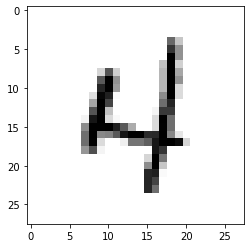

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.data
train_data = train.transform(train_data.numpy())

print(train.data.shape)
print(train_data.shape)

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

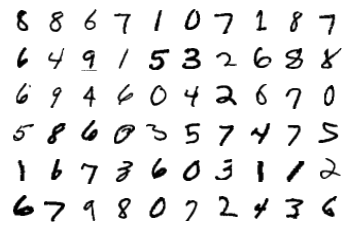

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        x = x.view(-1, 10) #1x1x10> 10
        return F.log_softmax(x, dim=-1)

# Receptive Field Calculations for all layers.

n_in | RF_in | k | p | s | J_in | J_out | RF_out | n_out | layer
-----|-------|---|---|---|------|-------|--------|-------|---------
28   |   1   | 3 | 1 | 1 | 1    |   1   |   3    |  28   | conv1
28   |   3   | 3 | 1 | 1 | 1    |   1   |   5    |  28   | conv2
28   |   5   | 2 | 0 | 2 | 1    |   2   |   6    |  14   | pool1
14   |   6   | 3 | 1 | 1 | 2    |   2   |   10   |  14   | conv3
14   |   10  | 3 | 1 | 1 | 2    |   2   |   14   |  14   | conv4
14   |   14  | 2 | 0 | 2 | 2    |   4   |   16   |   7   | pool2
 7   |   16  | 3 | 0 | 1 | 4    |   4   |   24   |   5   | conv5
 5   |   24  | 3 | 0 | 1 | 4    |   4   |   32   |   3   | conv6
 3   |   32  | 3 | 0 | 1 | 4    |   4   |   40   |   1   | conv7

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
batch_size = 20
s = summary(
    model,
    input_size=(batch_size, 1, 28, 28),
    verbose=1,
    col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", "trainable"],
    row_settings=["var_names"]
)

cuda
Layer (type (var_name))                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
Net (Net)                                --                        [20, 1, 28, 28]           [20, 10]                  --                        --                        True
├─Conv2d (conv1)                         [3, 3]                    [20, 1, 28, 28]           [20, 32, 28, 28]          320                       5,017,600                 True
├─Conv2d (conv2)                         [3, 3]                    [20, 32, 28, 28]          [20, 64, 28, 28]          18,496                    290,017,280               True
├─MaxPool2d (pool1)                      2                         [20, 64, 28, 28]          [20, 64, 14, 14]          --                        --                        --
├─Conv2d (conv3)                         [3, 3]                    [20, 64, 14, 14]          [20, 128, 14, 14]  

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  # epoch accuracy = accuracy for the whole batch
  epoch_train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.08914521336555481 Batch_id=468 Accuracy=87.66: 100%|██████████| 469/469 [00:06<00:00, 73.35it/s]


Test set: Average loss: 0.0575, Accuracy: 9815/10000 (98.15%)

EPOCH: 1


Loss=0.03610089793801308 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:05<00:00, 79.45it/s]


Test set: Average loss: 0.0381, Accuracy: 9883/10000 (98.83%)

EPOCH: 2


Loss=0.018999887630343437 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:06<00:00, 76.85it/s]


Test set: Average loss: 0.0358, Accuracy: 9884/10000 (98.84%)

EPOCH: 3


Loss=0.03429332748055458 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:05<00:00, 79.88it/s]


Test set: Average loss: 0.0305, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


Loss=0.043240830302238464 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:05<00:00, 81.01it/s]


Test set: Average loss: 0.0296, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.011181042529642582 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:05<00:00, 80.16it/s]


Test set: Average loss: 0.0289, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.003364111529663205 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:06<00:00, 77.43it/s]


Test set: Average loss: 0.0343, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.0006873363745398819 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:05<00:00, 79.72it/s]


Test set: Average loss: 0.0332, Accuracy: 9913/10000 (99.13%)

EPOCH: 8


Loss=0.008404902182519436 Batch_id=468 Accuracy=99.77: 100%|██████████| 469/469 [00:05<00:00, 78.75it/s]


Test set: Average loss: 0.0273, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.0004422465281095356 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:05<00:00, 79.31it/s]


Test set: Average loss: 0.0292, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


Loss=0.004560295958071947 Batch_id=468 Accuracy=99.82: 100%|██████████| 469/469 [00:05<00:00, 78.77it/s]


Test set: Average loss: 0.0307, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.0001756575657054782 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:05<00:00, 79.67it/s]


Test set: Average loss: 0.0365, Accuracy: 9904/10000 (99.04%)

EPOCH: 12


Loss=0.002852389356121421 Batch_id=468 Accuracy=99.92: 100%|██████████| 469/469 [00:05<00:00, 79.61it/s]


Test set: Average loss: 0.0315, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.0005332592409104109 Batch_id=468 Accuracy=99.95: 100%|██████████| 469/469 [00:05<00:00, 78.38it/s]


Test set: Average loss: 0.0322, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.0005054267239756882 Batch_id=468 Accuracy=99.95: 100%|██████████| 469/469 [00:05<00:00, 78.31it/s]


Test set: Average loss: 0.0367, Accuracy: 9922/10000 (99.22%)



Text(0.5, 1.0, 'Test Accuracy')

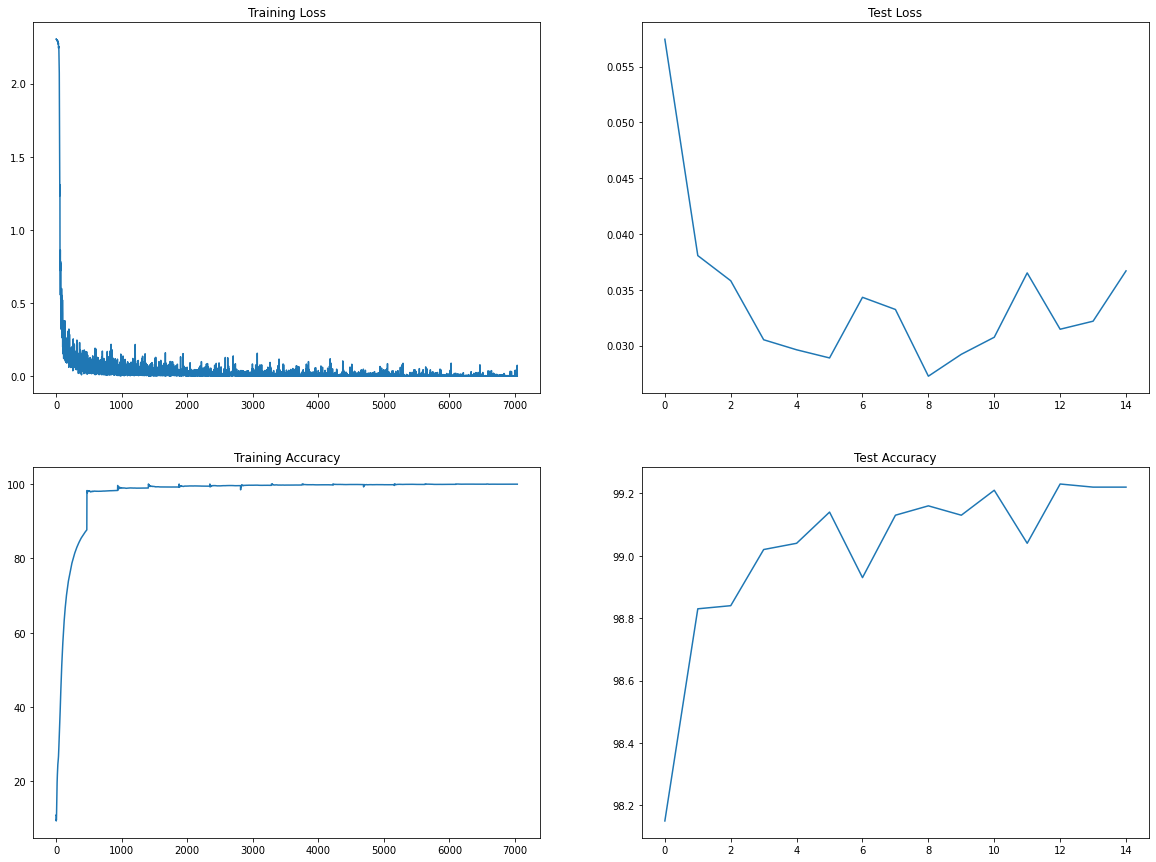

In [12]:
fig, axs = plt.subplots(2,2,figsize=(20,15))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [15]:
print("Minimum training loss = {:.9f}%".format(min(train_losses)))
print("Minimum testing loss = {:.9f}%".format(min(test_losses)))
print("Best training accuracy = {:.2f}%".format(max(epoch_train_acc)))
print("Best testing accuracy = {:.2f}%".format(max(test_acc)))

Minimum training loss = 0.000003198%
Minimum testing loss = 0.027252963%
Best training accuracy = 99.95%
Best testing accuracy = 99.23%



# Target:

1.  Get the set-up right
2.  Set Transforms
3.  Set Data Loader
4.  Set Basic Working Code
5.  Set Basic Training  & Test Loop

# Results:

*   Parameters = 6,379,786
*   Best training accuracy = 99.95%
*   Best testing accuracy = 99.23%

# Analysis:

*   Extremely Heavy Model for such a problem
*   Model is over-fitting
*   This was just to setup the structure of the code and we'll improve upon it in later iterations